**Calibration of spatial deterministic model**
with vaccination, VOC, and seasonality implemented as rescaling parameters

Setup:
1. Level of provinces (with the correct P-matrices and TDPF)
2. With VOC-induced increased hospitalisation propensity
3. ...

# Load Python packages

In [1]:
# Load packages
# Established packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from covid19model.models.models import COVID19_SEIQRD_spatial_stratified_rescaling, jit_main_function_spatial
from covid19model.models.utils import initialize_COVID19_SEIQRD_stratified_vacc

# Import time-dependent parameter functions for resp. P, Nc, alpha, N_vacc, season_factor
from covid19model.models.time_dependant_parameter_fncs import make_mobility_update_function, \
                                                          make_contact_matrix_function, \
                                                          make_VOC_function, \
                                                          make_vaccination_rescaling_function, \
                                                          make_seasonality_function_NEW

# Import packages containing functions to load in data used in the model and the time-dependent parameter functions
from covid19model.data import mobility, sciensano, model_parameters, VOC

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
# This may be useful because the `covid19model` package is under construction
%autoreload 2

# Spatial stratification
agg = 'prov'

# Load model parameter values
The model is supported by many parameters, which must be loaded into the model later on

In [2]:
# Population size, interaction matrices and the model parameters
initN, Nc_dict, params, CORE_samples_dict = model_parameters.get_COVID19_SEIQRD_parameters(spatial='prov')

# Google Mobility data (for social contact Nc)
df_google = mobility.get_google_mobility_data(update=False, provincial=True)

# Load and format mobility dataframe (for mobility place)
proximus_mobility_data = mobility.get_proximus_mobility_data('prov')

# Variants of concern
VOCs = ['WT', 'abc', 'delta']
VOC_logistic_growth_parameters, VOC_params = model_parameters.get_COVID19_SEIQRD_VOC_parameters(initN, params['h'], VOCs=VOCs)
params.update(VOC_params)

# Load and format local vaccination-induced rescaling data, which is also under the sciensano object
rescaling_df = sciensano.get_vaccination_rescaling_values(spatial=True)

In [3]:
# Delete parameters that are superfluous for the new approach

superfluous_params = ['f_immune_escape', 'e_s', 'e_h', 'e_i', 'doses', 'd_vacc', 'N_vacc', 'daily_doses', 'delay_immunity', 'vacc_order', 'stop_idx', 'refusal', 'initN', 'default_mobility', 'onset_days']
for key in superfluous_params:
    if key in params:
        params.pop(key)
        
# Add new parameters (these will be time-dependent soon)
params['E_susc'] = np.ones([11, 10])
params['E_inf'] = np.ones([11, 10])
params['E_hosp'] = np.ones([11, 10])

# Add seasonality parameter
params['seasonality'] = 1

# Change default value of K_inf (by including K_hosp, the default values can no longer be even close to true)
params['K_inf'] = np.array([1.5, 1], np.float64)
params['K_hosp'] = np.array([1.01, 1], np.float64)

In [4]:
##################################################
## Construct time-dependent parameter functions ##
##################################################

# Time-dependent social contact matrix over all policies, updating Nc
policy_function = make_contact_matrix_function(df_google, Nc_dict).policies_all_spatial
policy_function_work = make_contact_matrix_function(df_google, Nc_dict).policies_all_work_only

# Time-dependent mobility function, updating P (place)
mobility_function = \
    make_mobility_update_function(proximus_mobility_data).mobility_wrapper_func

# Time-dependent VOC function, updating alpha
VOC_function = make_VOC_function(VOC_logistic_growth_parameters)

# Time-dependent vaccination-induced rescaling parameter functions, updating E_susc^g, E_inf^g, E_hosp^g
E_susc_function = make_vaccination_rescaling_function(rescaling_df).E_susc
E_inf_function = make_vaccination_rescaling_function(rescaling_df).E_inf
E_hosp_function = make_vaccination_rescaling_function(rescaling_df).E_hosp

# Time-dependent seasonality function, updating season_factor
seasonality_function = make_seasonality_function_NEW()

# Initialise model
The spatial model must have an initial condition. These choices have been determined with a prior calibration and saved in a `pickle` file that is loaded below

In [5]:
####################
## Initial states ##
####################

start_calibration = '2020-03-17'

import pickle
data_path = "../../data/"

# Get correct initial condition
samples_path = data_path + 'interim/model_parameters/COVID19_SEIQRD/initial_conditions/prov/'

with open(samples_path+'initial_states-COVID19_SEIQRD_spatial.pickle', 'rb') as handle:
    load = pickle.load(handle)
    initial_states = load[start_calibration]

In [6]:
##########################
## Initialize the model ##
##########################

# Initiate model with initial states, defined parameters, and proper time dependent functions
model = COVID19_SEIQRD_spatial_stratified_rescaling(initial_states, params, spatial='prov',
                        time_dependent_parameters={'Nc' : policy_function,
                                                'Nc_work' : policy_function_work,
                                                'place' : mobility_function,
                                                'f_VOC' : VOC_function,
                                                'E_susc' : E_susc_function,
                                                'E_inf' : E_inf_function,
                                                'E_hosp' : E_hosp_function,
                                                'seasonality' : seasonality_function})

In [7]:
########################
## Run the model once ##
########################

# takes approximately 20 seconds on Michiel's local device
# Can be halved by using RK23 with larger relative tolerance

end_test_run = '2021-12-31'

warmup = 0
out = model.sim(end_test_run,start_date=start_calibration,warmup=warmup)

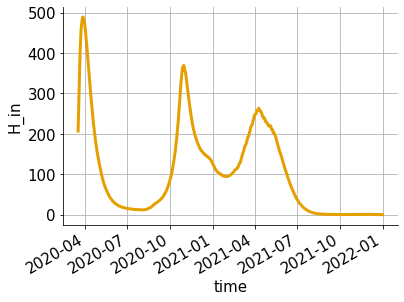

In [8]:
##############################
## Show the test run result ##
##############################

out['H_in'].sum(dim='place').sum(dim='Nc').plot()

# Load and show all hospitalisation data per arrondissement
The model is calibrated on daily new hospitalisations (`H_in`). This data is found in the nonpublic repository. 7-day averaged data is available from March 5th 2020. This is almost two weeks prior to the first lockdown (March 18th). Mobility data is available for this date.

In [ ]:
nonpublic_ts = sciensano.get_sciensano_COVID19_data_spatial(agg=agg, values='hospitalised_IN', moving_avg=True)
nonpublic_ts.tail(2)

In [ ]:
# Show all 43 time series and one selection
fig, (ax2, ax3) = plt.subplots(2, 1, figsize=(16, 4))

nonpublic_ts.plot(ax=ax2, linewidth=0, kind='area')
ax2.legend().remove()
ax2.grid(False)
xlabel=ax2.set_xlabel(None)
title=ax2.set_title(f'Daily new hospitalisations per {agg} (7-day moving average)')
ylim=ax2.set_ylim([0, 600])

# Add data for one NIS
NIS_choice=21000
nonpublic_ts[[NIS_choice]].plot(ax=ax3)
# ax3.legend().remove()
ax3.grid(False)
# title=ax3.set_title(f'Daily new hospitalisations for NIS {NIS_choice} (7-day moving average)')

for ax in fig.get_axes():
    ax.label_outer()

# Calibration

The code below is mostly copied from `JV-calibration-COVID19-SEIRD-WAVE1.ipynb` and the functions used there.

In [ ]:
# Date of first data collection
start_calibration = '2020-03-05' # first available date
# Last datapoint used to calibrate prevention parameters
end_calibration = '2020-07-01'

# Path where figures should be stored
fig_path = '../../results/calibrations/COVID19_SEIRD/national/'
# Path where MCMC samples should be saved
samples_path = '../../data/interim/model_parameters/COVID19_SEIRD/calibrations/national/'
# Spatial unit: identifier
spatial_unit = f'{agg}_willem2012_prev_thin'

In [ ]:
# define dataset from the start and end date
data=[nonpublic_ts[start_calibration:end_calibration]]

# Define the compartment that the calibration will be looking at
states = [["H_in"]]

In [ ]:
# Initial value for warmup time
init_warmup = 30

# Parameters for PSO
maxiter = 100
popsize = 5

# Number of parallel processors used
processes = 4

# Parameters for MCMC
steps_mcmc = 3000 #3000
discard = 1000 #1000

In [ ]:
############################################################
####### CALIBRATING WARMUP, BETA AND COMPLIANCE RAMP #######
############################################################

print('------------------------------------')
print('CALIBRATING BETA AND COMPLIANCE RAMP')
print('------------------------------------\n')
print('Using data from '+start_calibration+' until '+end_calibration+'\n')
print('1) Particle swarm optimization\n')

# set PSO optimisation settings
parNames = ['warmup', 'beta_R', 'beta_U', 'beta_M', 'l', 'tau']
bounds=((10,80), (0.010,0.060), (0.010,0.060), (0.010,0.060), (0.1,20), (0.1,20))

# run PSO optimisation
# theta_pso = pso.fit_pso(model_wave1,data,parNames,states,bounds,maxiter=maxiter,popsize=popsize,
#                     start_date=start_calibration,warmup=init_warmup, processes=processes, dist='poisson', poisson_offset=1, agg=agg) 
# warmup = int(theta_pso[-1])

# Scratches

## Only show upper graph of H_in timeseries

In [ ]:
# Show all 43 time series and one selection
fig, ax69 = plt.subplots(figsize=(12, 7))

nonpublic_ts.plot(ax=ax69, linewidth=0, kind='area')
ax69.legend().remove()
ax69.grid(False)
xlabel=ax69.set_xlabel(None)
ylabel=ax69.set_ylabel(r'$H_{in}$',size=18)
title=ax69.set_title(f'Daily new hospitalisations per arrondissement (7-day moving average)', size=18)
ylim=ax69.set_ylim([0, 650])

plt.savefig("daily-new-hosp_arr_until-31032021", dpi=400, bbox_inches='tight')

## Plot preliminary results from PSO

In [ ]:
# Fill in data from PSO (ran from console)
#initial conditions
initE = initial_state(dist='bxl', agg=agg, age=40, number=1) # 1 40-somethings dropped in Brussels (arrival by plane)
initial_states = {'S': initN, 'E': initE}
#parameters
params.update({"beta_R": 0.05911714228791011, # taken from corner plot
               "beta_U": 0.05807289680441654, # taken from corner plot
               "beta_M": 0.05370565085646678, # taken from corner plot
               "l": 12.93255574616446, # taken from corner plot
               "tau": 0.1}) # fixed
warmup=35 # taken from PSO
start_calibration = '2020-03-05'

# Execute simulation with these data
#initiate model with initial states, defined parameters, and wave1_policies determining the evolution of Nc
model_wave1 = models.COVID19_SEIRD_spatial(initial_states, params, time_dependent_parameters = \
                                           {'Nc' : tdpf.wave1_policies, 'place' : tdpf.mobility_update_func}, spatial=agg)
#simulate
out = model_wave1.sim(end_date, start_date=start_calibration, warmup=warmup)#, N=2)

In [ ]:
# sum total
fig, ax = plt.subplots(figsize=(16,5))

out["H_in"].sum(dim='Nc').sum(dim='place').plot(ax=ax, label='simulation')
nonpublic_ts.sum(axis=1).plot(ax=ax, label='data', style='.')
plt.plot()
ax.grid(False)
ax.legend()
title=ax.set_title("Comparison between preliminary PSO results and Sciensano data. Summed over all NIS codes.")

In [ ]:
# Individual
NIS=11000

fig, ax = plt.subplots(figsize=(16,5))

out["H_in"].sum(dim='Nc').sel(place=NIS).plot(ax=ax, label='simulation')
nonpublic_ts[[NIS]].plot(ax=ax, label='data', style='.')
plt.plot()
ax.grid(False)
ax.legend()
title=ax.set_title("Comparison between preliminary PSO results and Sciensano data. For one NIS code.")

In [ ]:
df_sciensano = sciensano.get_sciensano_COVID19_data_spatial(agg=agg, moving_avg=True, values='hospitalised_IN')

fig,ax = plt.subplots(figsize=(10,5))
ax.scatter(df_sciensano.index, df_sciensano[[32000]], color='black', alpha=0.6, linestyle='None', facecolors='none', s=60, linewidth=2)

## Test the relation between length of `l` and execution time
I suspect that low `l` values imply that the discontinuity is 'stronger', meaning that the ODE solver needs more time steps

In [ ]:
# Fill in data from PSO (ran from console)
#initial conditions
initE = initial_state(dist='bxl', agg=agg, age=40, number=1) # 1 40-somethings dropped in Brussels (arrival by plane)
initial_states = {'S': initN, 'E': initE}

import time

lrange = list(np.arange(1,20,1))
times = np.array([])

for l in np.arange(1, 20, 1):
    start_time = time.time()
    # execute code
    params.update({"beta_R": 0.0502,
                   "beta_U": 0.0350,
                   "beta_M": 0.035,
                   "l": l, #
                   "tau": 0.1}) # fixed
    warmup=59
    start_calibration = '2020-03-05'

    # Execute simulation with these data
    #initiate model with initial states, defined parameters, and wave1_policies determining the evolution of Nc
    model_wave1 = models.COVID19_SEIRD_spatial(initial_states, params, time_dependent_parameters = \
                                               {'Nc' : tdpf.wave1_policies, 'place' : tdpf.mobility_update_func}, spatial=agg)
    #simulate
    out = model_wave1.sim(end_date, start_date=start_calibration, warmup=warmup)#, N=2)
    
    time_it_took = time.time() - start_time
    times = np.append(times, time_it_took)

In [ ]:
# Actually kind of the opposite of what I was expecting
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(lrange,times)
ax.set_xlabel('$l$ compliance value', size=18)
ax.set_ylabel('Computation time (s)', size=18)

In [ ]:
test = np.array([[1, 2, 3], [4, np.nan, 6]])
np.nanmin(test)

## Manual code for plotting from samples_dict

In [ ]:
import json
import random

dict_file = "../../data/interim/model_parameters/COVID19_SEIRD/calibrations/arr/arr_willem2012_warmup_betas_comp_BETAs-comp_2021-03-31.json"

# Copied from mrollier-calibration_wave1
def draw_fcn(param_dict,samples_dict):
    # pick one random value from the dictionary
    idx, param_dict['beta_R'] = random.choice(list(enumerate(samples_dict['beta_R'])))
    # take out the other parameters that belong to the same iteration
    param_dict['beta_U'] = samples_dict['beta_U'][idx]
    param_dict['beta_M'] = samples_dict['beta_M'][idx]
    param_dict['l'] = samples_dict['l'][idx]
    return param_dict

with open(dict_file) as json_file:
    param_dict = json.load(json_file)
    
np.median(param_dict['l'])

In [ ]:
theta_pso = np.array([0.05, 0.04, 0.03, 15])
nwalkers=50

perturbation_beta_fraction = 1e-2
perturbation_comp_fraction = 10e-2
perturbations_beta = theta_pso[:3] * perturbation_beta_fraction * np.random.uniform(low=-1,high=1,size=(nwalkers,3))
perturbations_comp = theta_pso[3:] * perturbation_comp_fraction * np.random.uniform(low=-1,high=1,size=(nwalkers,1))
perturbations = np.concatenate((perturbations_beta,perturbations_comp), axis=1)
pos = theta_pso + perturbations

np.linalg.cond(pos)

# np.linalg.cond(np.array([[1, 2], [2, 4]]))

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))
df_google[['retail_recreation']].plot(ax=ax)
df_google[['work']].plot(ax=ax)
ax.set_ylabel('percentage to baseline', size=20)
ax.set_xlabel(None)
plt.legend(prop={'size':18})
ax.grid(False)

plt.savefig("Google-mob-data_retail-and-work.png", dpi=400, bbox_inches='tight')

## Sketch book

In [ ]:
from covid19model.models.time_dependant_parameter_fncs import make_mobility_update_function#, mobility_wrapper_func

df_google = mobility.get_google_mobility_data(update=False, plot=False)
# Load interaction matrices. Data taken from willem2012. No CoMix data used yet!
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = model_parameters.get_interaction_matrices(dataset='willem_2012', spatial=agg)
# levels = initN.size
Nc_all = {'total': Nc_total, 'home':Nc_home, 'work': Nc_work, 'schools': Nc_schools, 'transport': Nc_transport, 'leisure': Nc_leisure, 'others': Nc_others}


proximus_mobility_data, proximus_mobility_data_avg = mobility.get_proximus_mobility_data('arr')
mobility_update_func = make_mobility_update_function(proximus_mobility_data, proximus_mobility_data_avg)


In [ ]:
t = pd.to_datetime('2020-09-01 16:21:00')
states = 0
param = 0
mobility_wrapper_func(t, states, param, mobility_update_func)

In [ ]:
from covid19model.models.time_dependant_parameter_fncs import make_contact_matrix_function

policies_wave1_4prev = make_contact_matrix_function(df_google, Nc_all).policies_wave1_4prev

policies_wave1_4prev?

In [ ]:
t = pd.to_datetime('2020-04-01 16:21:00')
states = 0
param = 0
l = 5
tau = 5
prev_schools=0.5
prev_work=0.5
prev_rest=0.5
prev_home=0.5

policies_wave1_4prev(t, states, param, l, tau, prev_schools, prev_work, prev_rest, prev_home)

In [ ]:
df_sciensano = sciensano.get_sciensano_COVID19_data_spatial(agg=agg, moving_avg=True, values='hospitalised_IN')
df_sciensano[df_sciensano['DATE']<pd.Timestamp('2020-04-20')]

## Make corner plots

In [ ]:
from covid19model.optimization.run_optimization import samples_dict_to_emcee_chain # used for corner plots
import json
import corner

# All necessary information to make a corner plot is in the samples_dict dictionary
# Based on Notebooks/calibration/emcee-manual-thinning
fig_path = f'../../results/calibrations/COVID19_SEIRD/arr/'
signature = 'local-run_init-DATA_100xPSO_1000xMCMC'
spatial_unit = signature + "_first"
run_date = '2021-05-01'
filename = 'local-run_init-DATA_100xPSO_1000xMCMC_first_BETAs-prelockdown_2021-05-01.json'
samples_dict = json.load(open(f'../../data/interim/model_parameters/COVID19_SEIRD/calibrations/arr/{filename}'))

parNames_mcmc = ['beta_R', 'beta_U', 'beta_M']
labels = ['$\\beta_R$', '$\\beta_U$', '$\\beta_M$']
nwalkers=36
discard=0
thin=50

samples,flat_samples = samples_dict_to_emcee_chain(samples_dict, parNames_mcmc, nwalkers, discard=discard, thin=thin)

CORNER_KWARGS = dict(
    smooth=0.9,
    label_kwargs=dict(fontsize=14),
    title_kwargs=dict(fontsize=14),
    quantiles=[0.05, 0.95],
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    plot_density=True,
    plot_datapoints=False,
    fill_contours=True,
    show_titles=True,
    max_n_ticks=3,
    title_fmt=".3"
)
    # range=[(0,0.12),(0,5.2),(0,15)] # add this to CORNER_KWARGS if range is not automatically good

# Cornerplots of samples
fig = corner.corner(flat_samples, labels=labels, **CORNER_KWARGS)
# for control of labelsize of x,y-ticks:
# ticks=[[0,0.50,0.10],[0,1,2],[0,4,8,12],[0,4,8,12],[0,1,2],[0,0.25,0.50,1],[0,0.25,0.50,1],[0,0.25,0.50,1],[0,0.25,0.50,1]],
for idx,ax in enumerate(fig.get_axes()):
    ax.tick_params(axis='both', labelsize=12, rotation=0)

# Save figure
fig.show()
fig.savefig(fig_path+'cornerplots/'+spatial_unit+'_CORNER_BETAs-prelockdown_'+run_date+'.pdf', dpi=400, bbox_inches='tight')
# plt.close()

In [ ]:
from covid19model.optimization.run_optimization import samples_dict_to_emcee_chain # used for corner plots
import json
import corner

# All necessary information to make a corner plot is in the samples_dict dictionary
# Based on Notebooks/calibration/emcee-manual-thinning
fig_path = f'../../results/calibrations/COVID19_SEIRD/arr/'
signature = 'test2'
spatial_unit = signature
run_date = '2021-05-11'
filename = 'test2_2021-05-11.json'
samples_dict = json.load(open(f'../../data/interim/model_parameters/COVID19_SEIRD/calibrations/arr/{filename}'))

parNames_mcmc = ['beta_R', 'beta_U', 'beta_M', 'l', 'prev_home', 'prev_schools', 'prev_work', 'prev_rest']
labels = ['$\\beta_R$', '$\\beta_U$', '$\\beta_M$', '$l$', '$\Omega_{home}$', '$\Omega_{schools}$', '$\Omega_{work}$', '$\Omega_{rest}$']
nwalkers=96
discard=0
thin=50

samples,flat_samples = samples_dict_to_emcee_chain(samples_dict, parNames_mcmc, nwalkers, discard=discard, thin=thin)

CORNER_KWARGS = dict(
    smooth=0.9,
    label_kwargs=dict(fontsize=14),
    title_kwargs=dict(fontsize=14),
    quantiles=[0.05, 0.95],
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    plot_density=True,
    plot_datapoints=False,
    fill_contours=True,
    show_titles=True,
    max_n_ticks=3,
    title_fmt=".3"
)
    # range=[(0,0.12),(0,5.2),(0,15)] # add this to CORNER_KWARGS if range is not automatically good

# Cornerplots of samples
fig = corner.corner(flat_samples, labels=labels, **CORNER_KWARGS)
# for control of labelsize of x,y-ticks:
# ticks=[[0,0.50,0.10],[0,1,2],[0,4,8,12],[0,4,8,12],[0,1,2],[0,0.25,0.50,1],[0,0.25,0.50,1],[0,0.25,0.50,1],[0,0.25,0.50,1]],
for idx,ax in enumerate(fig.get_axes()):
    ax.tick_params(axis='both', labelsize=12, rotation=0)

# Save figure
fig.show()
# fig.savefig(fig_path+'cornerplots/'+spatial_unit+'_CORNER_BETAs_comp_postlockdown_'+run_date+'.pdf', dpi=400, bbox_inches='tight')
# plt.close()

## Make time series fit

## Test new contact matrix import function

In [ ]:
from covid19model.data.model_parameters import get_integrated_willem2012_interaction_matrices
from covid19model.models.utils import stratify_beta
initN, Nc_dict = get_integrated_willem2012_interaction_matrices(spatial='arr')

In [ ]:
# spatial = 'arr'
# initN_data = "../../data/interim/demographic/initN_" + spatial + ".csv"
# initN_df = pd.read_csv(initN_data, index_col='NIS')
# initN = initN_df.values[:,:-1]

In [ ]:
from covid19model.optimization.utils import perturbate_PSO, run_MCMC

theta = np.array([1.0, 1.0, 2.0])
pert = [0.01, 0.01, 0.05]
multiplier = 12
bounds=((0.01, 2), (0.01, 1), (1, 2))
perturbate_PSO(theta, pert, multiplier=multiplier, bounds=bounds)[2]

In [ ]:
# ------------------
# Create corner plot
# ------------------

# All necessary information to make a corner plot is in the samples_dict dictionary
# This should be put in a separate function

CORNER_KWARGS = dict(
    smooth=0.9,
    label_kwargs=dict(fontsize=14),
    title_kwargs=dict(fontsize=14),
    quantiles=[0.05, 0.95],
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    plot_density=True,
    plot_datapoints=False,
    fill_contours=True,
    show_titles=True,
    max_n_ticks=3,
    title_fmt=".3"
)
    # range=[(0,0.12),(0,5.2),(0,15)] # add this to CORNER_KWARGS if range is not automatically good

# Cornerplots of samples. Also uses flat_samples taken from get_chain method above
fig = corner.corner(flat_samples, labels=labels, **CORNER_KWARGS)
# for control of labelsize of x,y-ticks:
# ticks=[[0,0.50,0.10],[0,1,2],[0,4,8,12],[0,4,8,12],[0,1,2],[0,0.25,0.50,1],[0,0.25,0.50,1],[0,0.25,0.50,1],[0,0.25,0.50,1]],
for idx,ax in enumerate(fig.get_axes()):
    ax.tick_params(axis='both', labelsize=12, rotation=0)

# Save figure
fig.savefig(f'{fig_path}cornerplots/{signature}_CORNER_BETAs_prelockdown_{run_date}.pdf', dpi=400, bbox_inches='tight')
plt.close()

# ------------------------
# Define sampling function
# ------------------------

# Can't this be taken out of the script?
def draw_fcn(param_dict,samples_dict):
    # pick one random value from the dictionary
    idx, param_dict['beta_R'] = random.choice(list(enumerate(samples_dict['beta_R'])))
    # take out the other parameters that belong to the same iteration
    param_dict['beta_U'] = samples_dict['beta_U'][idx]
    param_dict['beta_M'] = samples_dict['beta_M'][idx]
    return param_dict

# ----------------
# Perform sampling
# ----------------

# Takes n_samples samples from MCMC to make simulations with, that are saved in the variable `out`
print('\n4) Simulating using sampled parameters\n')
start_sim = start_calibration
end_sim = '2020-03-26' # only plot until the peak for this part
out = model_wave1.sim(end_sim,start_date=start_sim,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict)

# ----------------------------------------
# Define the simulation output of interest
# ----------------------------------------

# This is typically set at 0.05 (1.7 sigma i.e. 95% certainty)
LL = conf_int/2
UL = 1-conf_int/2

# Take sum over all ages for hospitalisations
H_in_base = out["H_in"].sum(dim='Nc')

# Save results for sum over all places. Gives n_samples time series
H_in = H_in_base.sum(dim='place').values
# Compute mean and median
H_in_mean = np.mean(H_in,axis=1)
H_in_median = np.median(H_in,axis=1)
# Compute quantiles
H_in_LL = np.quantile(H_in, q = LL, axis = 1)
H_in_UL = np.quantile(H_in, q = UL, axis = 1)

# Save results for every individual place. Same strategy.
H_in_places = dict({})
H_in_places_mean = dict({})
H_in_places_median = dict({})
H_in_places_LL = dict({})
H_in_places_UL = dict({})

for NIS in out.place.values:
    H_in_places[NIS] = H_in_base.sel(place=NIS).values
    # Compute mean and median
    H_in_places_mean[NIS] = np.mean(H_in_places[NIS],axis=1)
    H_in_places_median[NIS] = np.median(H_in_places[NIS],axis=1)
    # Compute quantiles
    H_in_places_LL[NIS] = np.quantile(H_in_places[NIS], q = LL, axis = 1)
    H_in_places_UL[NIS] = np.quantile(H_in_places[NIS], q = UL, axis = 1)

# -----------
# Visualising
# -----------

print('\n5) Visualizing fit \n')
# This should be taken out of the script for sure

# Plot
fig,ax = plt.subplots(figsize=(10,5))
# Incidence
ax.fill_between(pd.to_datetime(out['time'].values),H_in_LL, H_in_UL,alpha=0.20, color = 'blue')
ax.plot(out['time'],H_in_mean,'--', color='blue')

# Plot result for sum over all places. Black dots for data used for calibration, red dots if not used for calibration.
ax.scatter(df_sciensano[start_calibration:end_calibration].index, df_sciensano[start_calibration:end_calibration].sum(axis=1), color='black', alpha=0.6, linestyle='None', facecolors='none', s=60, linewidth=2)
ax.scatter(df_sciensano[pd.to_datetime(end_calibration)+datetime.timedelta(days=1):end_sim].index, df_sciensano[pd.to_datetime(end_calibration)+datetime.timedelta(days=1):end_sim].sum(axis=1), color='red', alpha=0.6, linestyle='None', facecolors='none', s=60, linewidth=2)
ax = _apply_tick_locator(ax)
ax.set_xlim(start_calibration,end_sim)
ax.set_ylabel('$H_{in}$ (-)')
fig.savefig(f'{fig_path}others/{signature}_FIT_BETAs_prelockdown_SUM_{run_date}.pdf', dpi=400, bbox_inches='tight')
plt.close()

# Create subdirectory
fit_prelockdown_subdir = f'{fig_path}others/{signature}_FIT_BETAs_prelockdown_NIS_{run_date}'
os.mkdir(fit_prelockdown_subdir)
# Plot result for each NIS
for NIS in out.place.values:
    fig,ax = plt.subplots(figsize=(10,5))
    ax.fill_between(pd.to_datetime(out['time'].values),H_in_places_LL[NIS], H_in_places_UL[NIS],alpha=0.20, color = 'blue')
    ax.plot(out['time'],H_in_places_mean[NIS],'--', color='blue')
    ax.scatter(df_sciensano[start_calibration:end_calibration].index, df_sciensano[start_calibration:end_calibration][[NIS]], color='black', alpha=0.6, linestyle='None', facecolors='none', s=60, linewidth=2)
    ax.scatter(df_sciensano[pd.to_datetime(end_calibration)+datetime.timedelta(days=1):end_sim].index, df_sciensano[pd.to_datetime(end_calibration)+datetime.timedelta(days=1):end_sim][[NIS]], color='red', alpha=0.6, linestyle='None', facecolors='none', s=60, linewidth=2)
    ax = _apply_tick_locator(ax)
    ax.set_xlim(start_calibration,end_sim)
    ax.set_ylabel('$H_{in}$ (-) for NIS ' + str(NIS))
    fig.savefig(f'{fit_prelockdown_subdir}/{signature}_FIT_BETAs_prelockdown_{str(NIS)}_{run_date}.pdf', dpi=400, bbox_inches='tight')
    plt.close()


###############################
####### CALCULATING R0 ########
###############################


print('-----------------------------------')
print('COMPUTING BASIC REPRODUCTION NUMBER')
print('-----------------------------------\n')

print('1) Computing\n')

# if spatial: R0_stratified_dict produces the R0 values resp. every region, every age, every sample.
# Probably better to generalise this to ages and NIS codes (instead of indices)
R0, R0_stratified_dict = calculate_R0(samples_dict, model_wave1, initN, Nc_total, agg=agg)

print('2) Sending samples to dictionary\n')

samples_dict.update({
    'R0': R0,
    'R0_stratified_dict': R0_stratified_dict,
})

print('3) Saving dictionary\n')

with open(f'{samples_path}{str(signature)}_BETAs_prelockdown_{run_date}.json', 'w') as fp:
    json.dump(samples_dict, fp)



In [ ]:
autocorr = np.zeros([1,3])
tau = [np.nan]*3
np.append(autocorr,np.transpose(np.expand_dims(tau,axis=1)),axis=0)

In [ ]:
from covid19model.optimization.utils import perturbate_PSO

processes=12
pert=[0.02, 0.02, 0.02]
theta=np.array([0.0451, 0.0413, 0.0501])
bounds=[(0.020,0.060), (0.020,0.060), (0.020,0.060)]
ndim, nwalkers, pos = perturbate_PSO(theta, pert, multiplier=processes, bounds=bounds)
np.linalg.cond(pos)

test = np.inf
while test == np.inf:
    print('nope')
    test -= 1